In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from luminol.anomaly_detector import AnomalyDetector

import warnings
warnings.filterwarnings('ignore')

In [9]:
df = pd.read_feather("measurement_data/ping-measurement_1.feather")
df

,index,created,probe_id,duplicates,rtt_average,rtt_max,rtt_min,rtt_median,dropped_packets
0,0,2021-06-07 00:02:11+00:00,6025,0,149.218,149.233853,149.195256,149.225,0
1,1,2021-06-07 00:02:21+00:00,6030,0,166.576,166.850203,166.409528,166.467,0
2,2,2021-06-07 00:02:22+00:00,6031,0,149.319,149.741417,149.048305,149.168,0
3,3,2021-06-07 00:02:21+00:00,6039,0,170.098,170.111447,170.077631,170.105,0
4,4,2021-06-07 00:02:17+00:00,6041,0,173.648,173.714002,173.588153,173.642,0
...,...,...,...,...,...,...,...,...,...
637530,678089,2021-06-09 23:58:21+00:00,7006,0,147.874,147.964410,147.811359,147.845,0
637531,678090,2021-06-09 23:58:17+00:00,7007,0,208.156,208.185379,208.128699,208.153,0
637532,678091,2021-06-09 23:58:09+00:00,7008,0,162.362,162.421941,162.276314,162.388,0
637533,678092,2021-06-09 23:58:08+00:00,7009,0,219.927,219.953030,219.913387,219.915,0


In [10]:
# Add row with difference to median for rtt_min
median_dict = {}
for i in df["probe_id"].unique():
    single_probe = df[df["probe_id"] == i]
    median_dict[i] = single_probe["rtt_min"].median()

def find_difference(probe_id, rtt_average):
    return rtt_average - median_dict[probe_id]

df["rtt_min_diff"] = np.vectorize(find_difference)(df['probe_id'], df['rtt_min'])

In [11]:
# Add row with difference to median for rtt_average
median_dict = {}
for i in df["probe_id"].unique():
    single_probe = df[df["probe_id"] == i]
    median_dict[i] = single_probe["rtt_average"].median()

def find_difference(probe_id, rtt_average):
    return rtt_average - median_dict[probe_id]

df["rtt_average_diff"] = np.vectorize(find_difference)(df['probe_id'], df['rtt_average'])

Probe ID: 6224
Median RTT: 263.90752 Average RTT: 276.6069166196665
Start date: 2021-06-07 00:02:10+00:00 End date: 2021-06-09 23:58:10+00:00 Measurement time: 2 days 23:56:00
Amount of data points: 1078


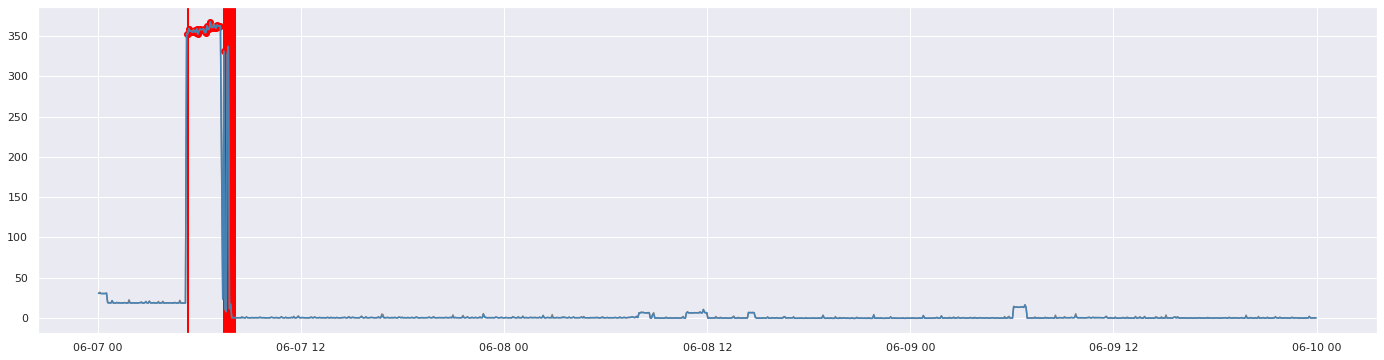

In [107]:
random_probe = df["probe_id"].sample(n=1, random_state=65).unique()[0]
# random_probe = 6229
print(f"Probe ID: {random_probe}")
single_probe1 = df[df["probe_id"] == random_probe]
single_probe1_median = single_probe1["rtt_min"].median()
single_probe1_mean = single_probe1["rtt_min"].mean()

print(f"Median RTT: {single_probe1_median} Average RTT: {single_probe1_mean}")

single_probe1_start = single_probe1["created"].min()
single_probe1_end = single_probe1["created"].max()
single_probe1_length = single_probe1_end - single_probe1_start
print(f"Start date: {single_probe1_start} End date: {single_probe1_end} Measurement time: {single_probe1_length}")

single_probe1_datapoints = len(single_probe1)
print(f"Amount of data points: {single_probe1_datapoints}")

# Outlier detection
clf = EllipticEnvelope(contamination=0.03)
single_probe1["outlier"] = clf.fit_predict(single_probe1[["rtt_min", "duplicates", "dropped_packets"]])

# Anomaly detection
algo_settings = {
      'precision':4, # how many sections to categorize values
      'lag_window_size':2, # lagging window size
      'future_window_size':2, # future window size,
      'chunk_size':4 # chunk size.
    }

ts = single_probe1["rtt_min"].to_dict()
detector = AnomalyDetector(ts, algorithm_name="bitmap_detector", algorithm_params=algo_settings)
anomalies = detector.get_anomalies()

fig, ax = plt.subplots(figsize=(24,6))

for anomaly in anomalies:
    start = single_probe1.at[anomaly.start_timestamp, "created"]
    end = single_probe1.at[anomaly.end_timestamp, "created"]
    score = anomaly.anomaly_score
    ax.axvspan(xmin=start, xmax=end, color="red")

a = single_probe1.loc[single_probe1['outlier'] == -1, ['created', 'rtt_min_diff']]
ax.plot(single_probe1['created'], single_probe1['rtt_average_diff'], color='grey')
ax.plot(single_probe1['created'], single_probe1['rtt_min_diff'], color='steelblue')
# 
ax.scatter(a["created"], a["rtt_min_diff"], color="red")
plt.show()

In [48]:
ts = single_probe1["rtt_min"].to_dict()
detector = AnomalyDetector(ts)
anomalies = detector.get_anomalies()

print(single_probe1.at[anomalies[1].start_timestamp, "created"])
print(single_probe1.at[anomalies[1].end_timestamp, "created"])
print(anomalies[1].anomaly_score)

2021-06-09 08:18:18+00:00
2021-06-09 08:30:20+00:00
27.415115080861625


<AxesSubplot:xlabel='rtt_min_diff', ylabel='Count'>

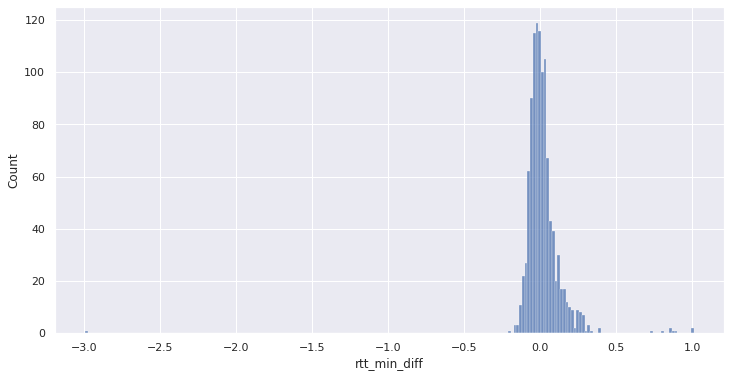

In [17]:
# check for normal distribution
sns.set(rc={"figure.figsize":(12, 6)})
sns.histplot(data=single_probe1, x="rtt_min_diff")

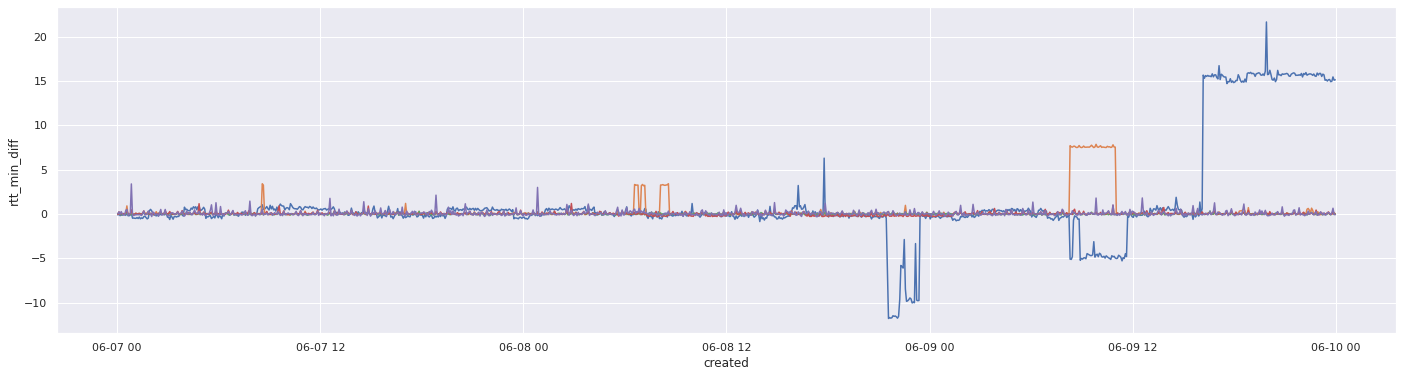

In [19]:
# compare 5 random probes to see if there is overlap in peaks
sns.set(rc={"figure.figsize":(24, 6)})
for i in df["probe_id"].sample(n=5):
    single_probe = df[df["probe_id"] == i]
    sns.lineplot(data=single_probe, x="created", y="rtt_min_diff")

In [176]:
# Find outliers in total dataset
# clf = OneClassSVM(nu=0.005, gamma=.01)
clf = EllipticEnvelope(contamination=0.03)
df_outlier = pd.DataFrame()
for i in df["probe_id"].unique():
    single_probe = df[df["probe_id"] == i]
    
    single_probe["outlier"] = clf.fit_predict(single_probe[["rtt_average", "rtt_max", "rtt_min", "rtt_median", "seconds_since_sync", "duplicates", "dropped_packets"]])
    single_probe["outlier_score"] = clf.mahalanobis(single_probe[["rtt_average", "rtt_max", "rtt_min", "rtt_median", "seconds_since_sync", "duplicates", "dropped_packets"]])
    single_probe["outlier"] = single_probe["outlier"].apply(lambda x: 0 if x == 1 else 1)
    df_outlier = df_outlier.append(single_probe)

display(df_outlier)

,created,probe_id,seconds_since_sync,duplicates,rtt_average,rtt_max,rtt_min,rtt_median,dropped_packets,diff_to_median,outlier,outlier_score
0,2021-06-07 00:02:11+00:00,6025,37.0,0,149.218,149.233853,149.195256,149.225,0,-0.132,0,2.853513
623,2021-06-07 00:06:18+00:00,6025,50.0,0,149.493,149.498309,149.487248,149.493,0,0.143,0,5.086854
1246,2021-06-07 00:10:17+00:00,6025,49.0,0,149.315,149.341522,149.265693,149.337,0,-0.035,0,1.527201
1868,2021-06-07 00:14:20+00:00,6025,58.0,0,149.209,149.391889,149.037659,149.199,0,-0.141,0,9.617539
2492,2021-06-07 00:18:18+00:00,6025,52.0,0,149.551,150.059528,149.242088,149.352,0,0.201,0,6.049215
...,...,...,...,...,...,...,...,...,...,...,...,...
675573,2021-06-09 23:42:14+00:00,7010,18.0,0,179.879,179.885990,179.872332,179.878,0,-0.045,0,5.187751
676203,2021-06-09 23:46:22+00:00,7010,212.0,0,179.884,179.903939,179.866280,179.880,0,-0.040,0,5.714167
676833,2021-06-09 23:50:16+00:00,7010,22.0,0,179.969,180.029638,179.929781,179.949,0,0.045,0,19.180474
677463,2021-06-09 23:54:20+00:00,7010,266.0,0,179.921,179.961030,179.863718,179.939,0,-0.003,0,8.531230


<AxesSubplot:xlabel='created'>

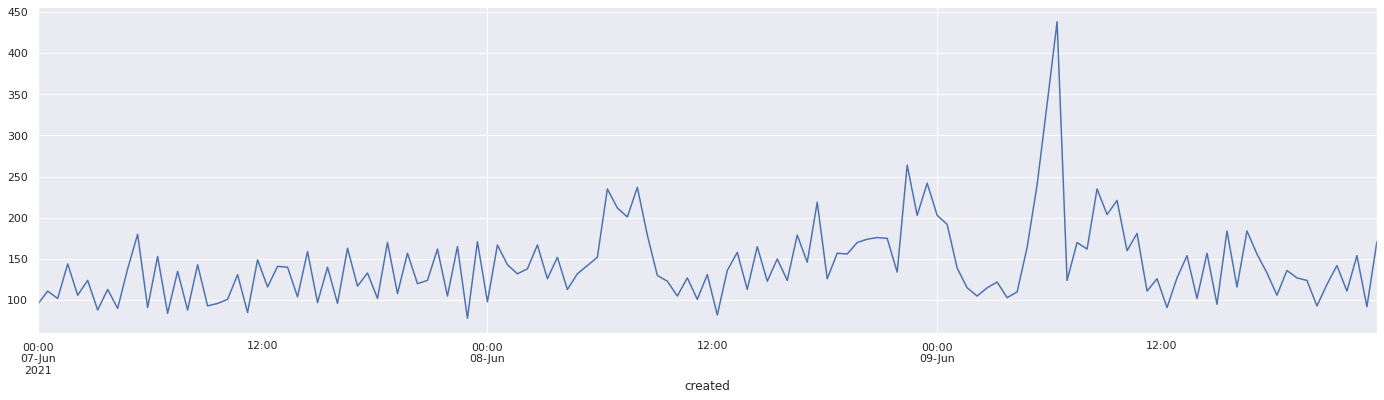

In [179]:
# Create anomaly score frame

df_outlier.groupby(pd.Grouper(key="created", freq="32T"))["outlier"].agg("sum").plot()

<AxesSubplot:xlabel='created'>

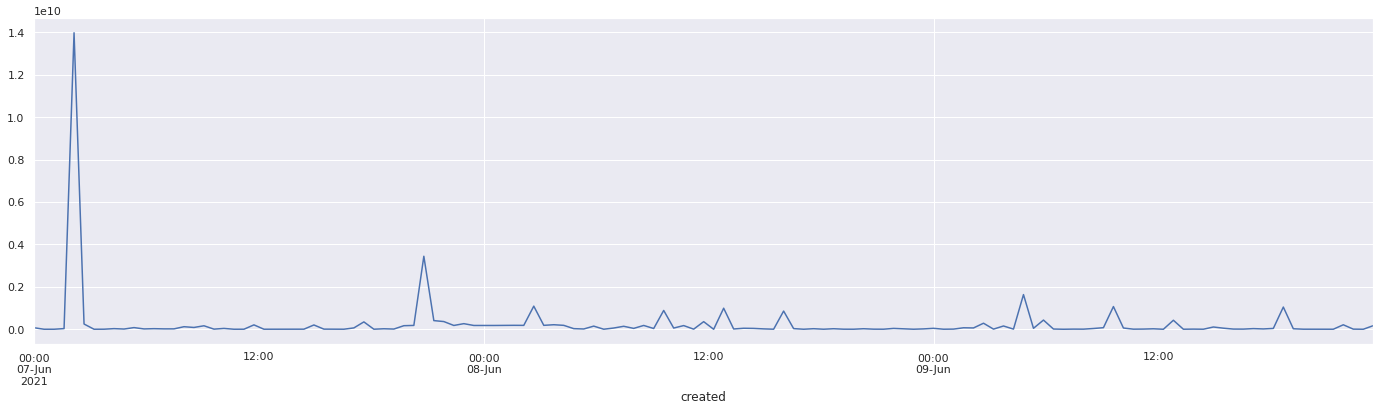

In [180]:
df_outlier.groupby(pd.Grouper(key="created", freq="32T"))["outlier_score"].agg("sum").plot()

In [188]:
single_probe = df_timeseries[df_timeseries["probe_id"] == 6025]
# ts = single_probe["rtt_average"].to_dict()


# detector = AnomalyDetector(ts)
# anomalies = detector.get_anomalies()
# print(anomalies[0])

TypeError: int() argument must be a string, a bytes-like object or a number, not 'Timestamp'